In [1]:
import os
import numpy as np
import pandas as pd
idx = pd.IndexSlice

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
colors = sns.color_palette()

In [2]:
from scipy import stats

from utils import abcd, plotting
ABCD_PATH = '../../ABCD'

# Functional Connectivity

In [3]:
fcon, fc_extra = abcd.load_mri_data(ABCD_PATH, 'fcon', dropna=True)

network_codes = [c for c in abcd.FCON.keys() if c != 'n']
subs = fcon.index.get_level_values(0).unique()
print(len(subs), 'subjects')

4188 subjects


In [4]:
covariates = abcd.load_covariates('output/abcd_covariates.csv', simple_race=True)

In [5]:
scan = fc_extra[abcd.SCAN_INFO].join(covariates['site_id']).fillna(method='bfill')

## One-way ANOVA

In [6]:
manufacts = scan.groupby('mri_info_manufacturer').groups
fcon_manufacts_F = stats.f_oneway(*[fcon.loc[ids] for ids in manufacts.values()])

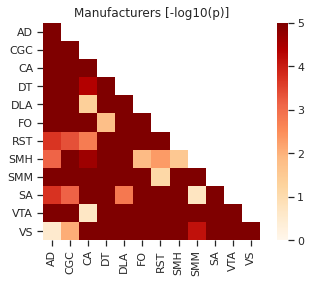

In [7]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(-np.log10(fcon_manufacts_F.pvalue),
                            cmap='OrRd', vmin=0, vmax=5)

ax.set_title('Manufacturers [-log10(p)]')
plt.show()

In [8]:
models = scan.loc[manufacts['SIEMENS']].groupby('mri_info_manufacturersmn').groups
fcon_models_F = stats.f_oneway(*[fcon.loc[ids] for ids in models.values()])

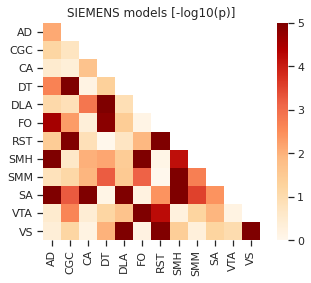

In [9]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(-np.log10(fcon_models_F.pvalue),
                            cmap='OrRd', vmin=0, vmax=5)

ax.set_title('SIEMENS models [-log10(p)]')
plt.show()

In [10]:
devices = scan.loc[models['Prisma_fit']].groupby('mri_info_deviceserialnumber').groups
fcon_devices_F = stats.f_oneway(*[fcon.loc[ids] for ids in devices.values()])

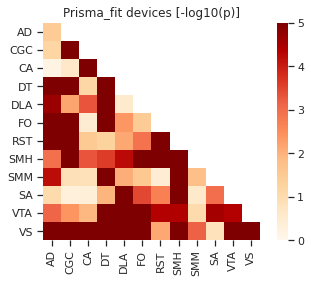

In [11]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(-np.log10(fcon_devices_F.pvalue),
                            cmap='OrRd', vmin=0, vmax=5)

ax.set_title('Prisma_fit devices [-log10(p)]')
plt.show()

In [12]:
sites = scan.groupby('site_id').groups
fcon_sites_F = stats.f_oneway(*[fcon.loc[ids] for ids in sites.values()])

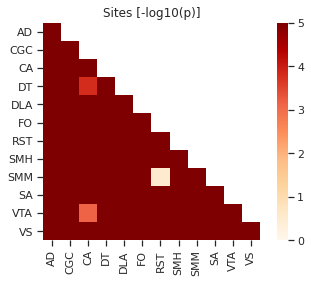

In [13]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(-np.log10(fcon_sites_F.pvalue),
                            cmap='OrRd', vmin=0, vmax=5)

ax.set_title('Sites [-log10(p)]')
plt.show()

## Univariate Regressions

In [14]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import tools as sm_tools

In [15]:
def confound_r2s(df, confounds, adjusted=False):
    exog = sm_tools.add_constant(pd.get_dummies(confounds.loc[df.index], drop_first=True))
    if adjusted:
        r2s = df.apply(lambda col: sm.OLS(col, exog).fit().rsquared_adj)
    else:
        r2s = df.apply(lambda col: sm.OLS(col, exog).fit().rsquared)
    
    return r2s

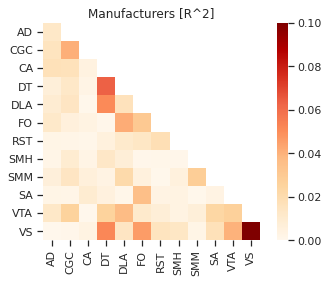

In [16]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(
        confound_r2s(fcon, scan['mri_info_manufacturer']),
        cmap='OrRd', vmax=0.10, vmin=0
    )

ax.set_title('Manufacturers [R^2]')
plt.show()

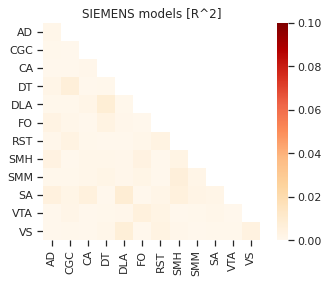

In [17]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(
        confound_r2s(fcon.loc[manufacts['SIEMENS']], scan['mri_info_manufacturersmn']),
        cmap='OrRd', vmax=0.10, vmin=0
    )

ax.set_title('SIEMENS models [R^2]')
plt.show()

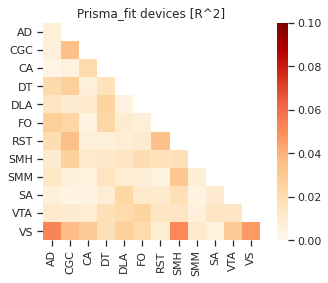

In [18]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(
        confound_r2s(fcon.loc[models['Prisma_fit']], scan['mri_info_deviceserialnumber']),
        cmap='OrRd', vmax=0.10, vmin=0
    )

ax.set_title('Prisma_fit devices [R^2]')
plt.show()

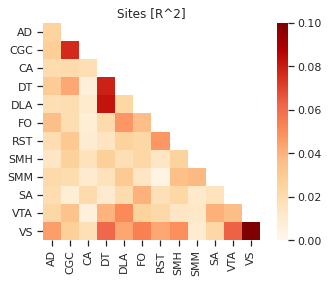

In [19]:
with sns.axes_style('ticks'):
    ax = plotting.plot_fcon(
        confound_r2s(fcon, scan['site_id']),
        cmap='OrRd', vmax=0.10, vmin=0
    )

ax.set_title('Sites [R^2]')
plt.show()

### Adjusted R2

In [20]:
confound_r2s(fcon, scan[abcd.SCAN_INFO], adjusted=True).describe()

count    78.000000
mean      0.027931
std       0.021074
min       0.001850
25%       0.015844
50%       0.022097
75%       0.038115
max       0.134232
dtype: float64

In [21]:
confound_r2s(
    fcon, scan[['mri_info_manufacturer', 'mri_info_deviceserialnumber']],
    adjusted=True
).describe()

count    78.000000
mean      0.026837
std       0.020867
min       0.001031
25%       0.014863
50%       0.020092
75%       0.034148
max       0.133379
dtype: float64

In [22]:
confound_r2s(
    fcon, scan[['mri_info_softwareversion', 'mri_info_deviceserialnumber']],
    adjusted=True
).describe()

count    78.000000
mean      0.027839
std       0.021229
min       0.001596
25%       0.015962
50%       0.022016
75%       0.037756
max       0.134478
dtype: float64

In [23]:
confound_r2s(
    fcon, scan['mri_info_deviceserialnumber'],
    adjusted=True
).describe()

count    78.000000
mean      0.027037
std       0.020950
min       0.001032
25%       0.014967
50%       0.020417
75%       0.034327
max       0.134483
dtype: float64

In [24]:
confound_r2s(
    fcon, scan[['mri_info_deviceserialnumber', 'site_id']],
    adjusted=True
).describe()

count    78.000000
mean      0.025927
std       0.020315
min      -0.000641
25%       0.014168
50%       0.019157
75%       0.033023
max       0.128014
dtype: float64

TODO
* subject similarity
* age x motion
* SC